### Stesp:
---
1. Import libraries
2. Load data & quick look at it 
3. Clean data
    - Duplicates
    - Null
    - Outliers
    - Column type
4. Save Cleaned Data
5. Some Analysis
6. Preprocessing Data
7. Make a pipeline
8. Choose the best model
9. Full pipeline

### import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# Model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# Metrics
from sklearn.metrics import r2_score, mean_squared_error
# Validation
from sklearn.model_selection import cross_val_score
# Save model
import joblib

### load data

In [3]:
BASE_DIR = os.getcwd()
DATA_PATH = os.path.join("..", "Data", "car_data.csv")

df = pd.read_csv(DATA_PATH)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


### Info:
---
- Data shape: (4340, 8)
- No nulls found
- No columns type need to change

In [5]:
# Quick Statistic describe
df.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


### Clean data

In [6]:
print(f'Duplicates: {df.duplicated().sum()}')

Duplicates: 763


In [7]:
df.drop_duplicates(inplace=True)
# inplace instead of df = df.function

In [8]:
print(f'Duplicates: {df.duplicated().sum()}')

Duplicates: 0


In [9]:
print(f'Null Values:\n{df.isnull().sum()}')

Null Values:
name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64


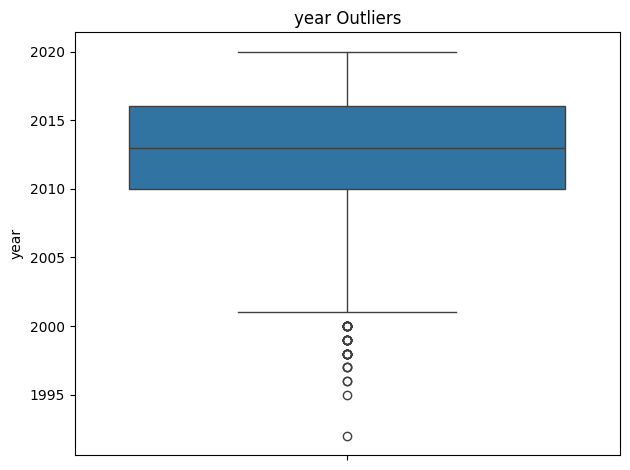

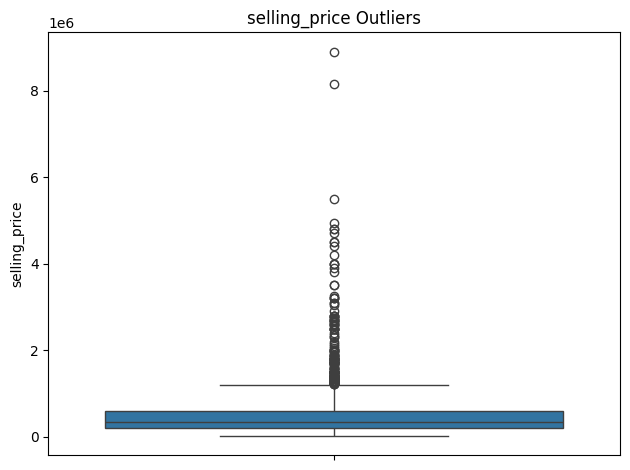

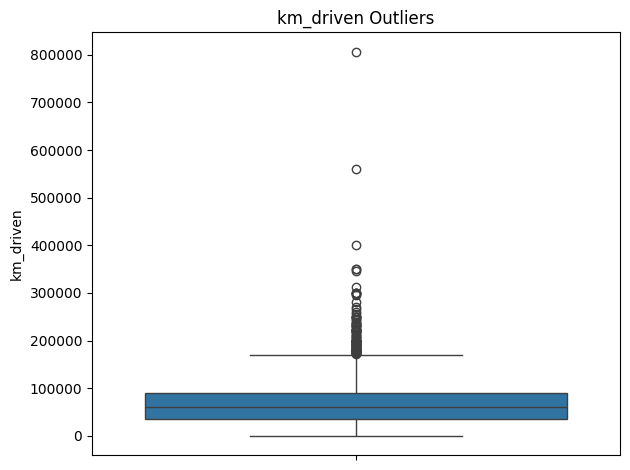

In [10]:
num_cols = df.select_dtypes(include=np.number).columns

for col in num_cols:
    sns.boxplot(df[col])
    plt.title(f'{col} Outliers')
    plt.tight_layout()
    plt.show()

In [11]:
def clean_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    upper = q3 + 1.5 * IQR
    lower = q1 - 1.5 * IQR
    return df[col].clip(lower, upper)

for col in num_cols:
    df[col] = clean_outliers(df, col)

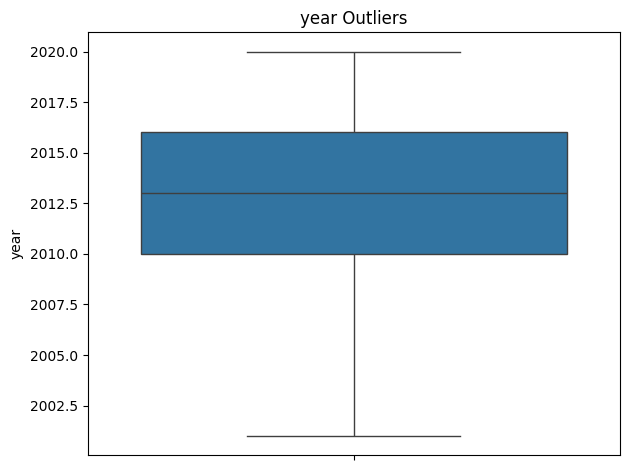

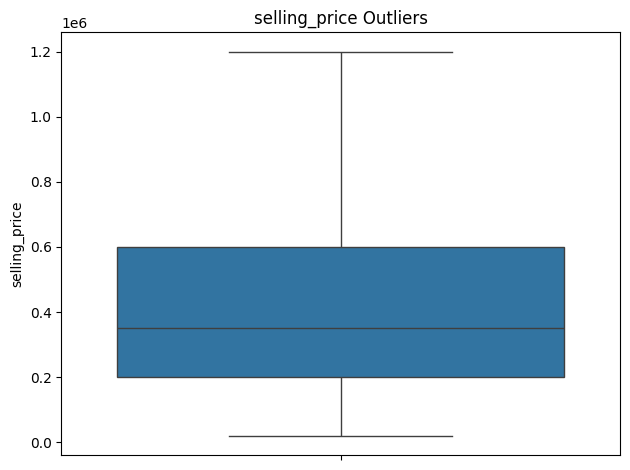

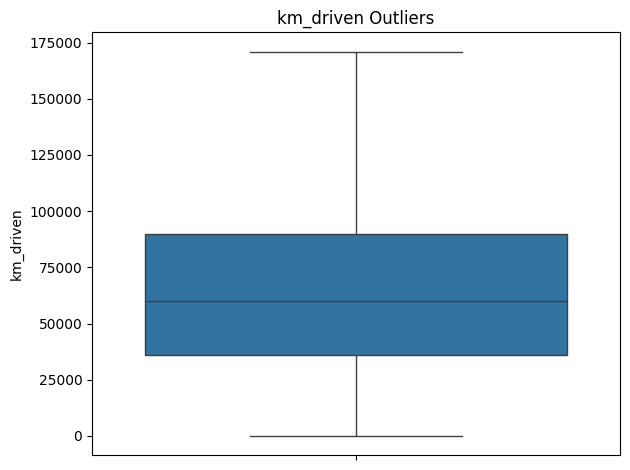

In [12]:
for col in num_cols:
    sns.boxplot(df[col])
    plt.title(f'{col} Outliers')
    plt.tight_layout()
    plt.show()

In [13]:
df['brand'] = df['name'].str.split(' ').str[0]
df.drop('name', axis=1, inplace=True)
df.to_csv('clean_car_data.csv', index=False)

### Analysis

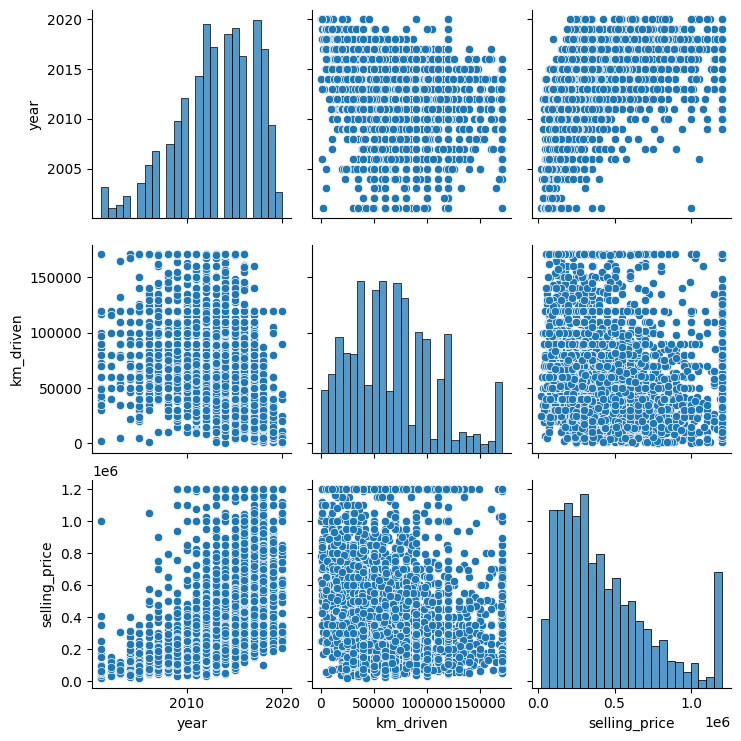

In [14]:
sns.pairplot(df[['year','km_driven','selling_price']])


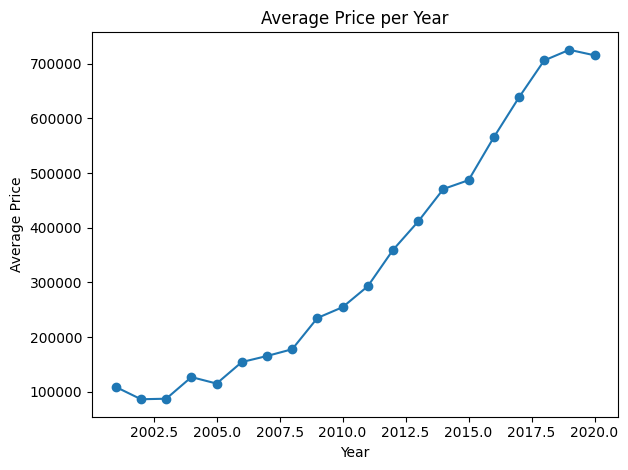

In [15]:
price_per_year = df.groupby('year').agg({'selling_price':'mean'}).sort_index()
plt.plot(price_per_year.index, price_per_year.values, marker='o')
plt.title('Average Price per Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Fuel Dustribution')

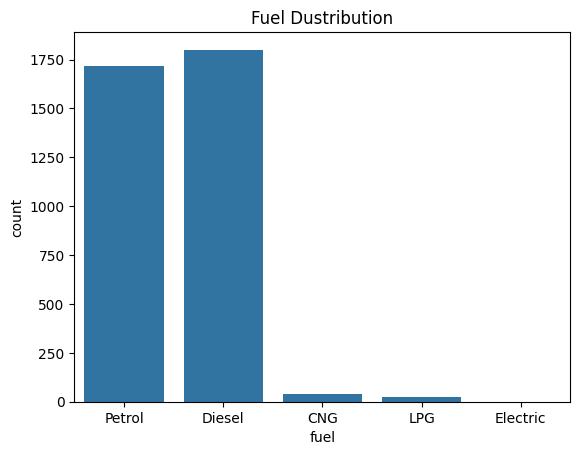

In [16]:
sns.countplot(data=df, x='fuel')
plt.title('Fuel Dustribution')

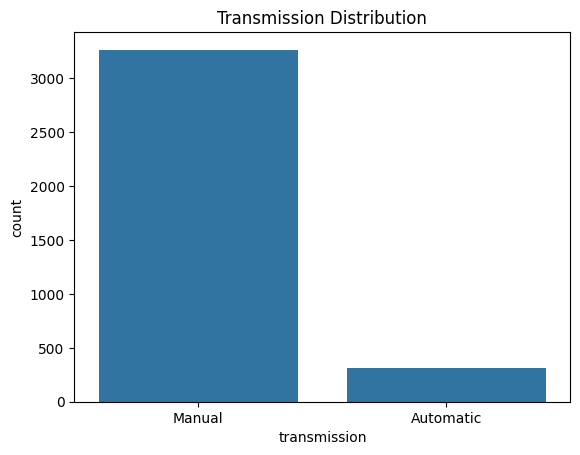

In [17]:
sns.countplot(data=df, x='transmission')
plt.title('Transmission Distribution')
plt.show()


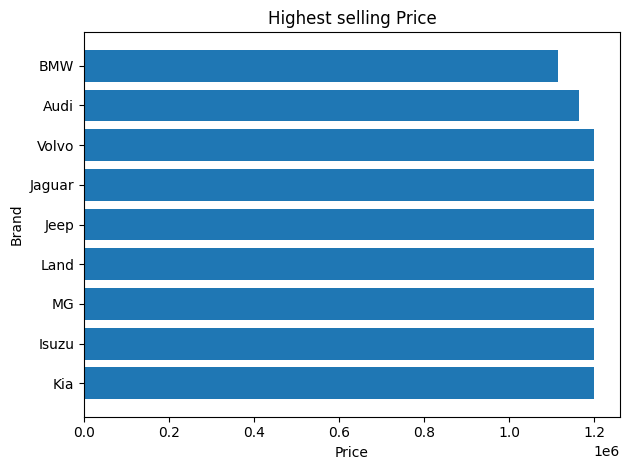

In [18]:
brand_price = df.groupby('brand')['selling_price'].mean().sort_values(ascending=False).head(9)
plt.barh(y=brand_price.index, width=brand_price.values)
plt.title('Highest selling Price')
plt.xlabel('Price')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

### Preprocessing


In [19]:
num_features = ['year', 'km_driven']
cat_features = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']

In [20]:
num_trans = Pipeline(steps=[
    ('scaler', StandardScaler())
])
cat_trans = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num_step', num_trans, num_features),
    ('cat_step', cat_trans, cat_features)
])


### Split

In [21]:
x = df.drop('selling_price', axis=1)
y = df['selling_price']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2,
                                random_state=42)

print(xtrain.columns)

Index(['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner',
       'brand'],
      dtype='object')


In [22]:
xtrain_pre = preprocessor.fit_transform(xtrain)
xtest_pre = preprocessor.transform(xtest)

### Choose Model

In [23]:
best_score = -float('inf')
best_name = ''
best_model = None

models = {'Linear': LinearRegression(),
         'Tree': DecisionTreeRegressor(),
         'RF': RandomForestRegressor(random_state=42),
         'XGBOOST': XGBRegressor(random_state=42)}

for name, model in models.items():
    print(f'Start {name} model training:')
    model.fit(xtrain_pre, ytrain)
    ypred = model.predict(xtest_pre)
    r2 = r2_score(ytest, ypred)
    print(f'R2 Score for {name} model : {r2:.2f}')
    mse = mean_squared_error(ytest, ypred)
    print(f'MSE for {name} model : {mse:.2f}')
    print('-'*30)
    

    if r2 > best_score:
        best_score = r2
        best_name = name
        best_model = model

print(f'Best Model is {best_name} with R2-score {best_score:.2f}')

Start Linear model training:
R2 Score for Linear model : 0.70
MSE for Linear model : 28200849539.66
------------------------------
Start Tree model training:
R2 Score for Tree model : 0.52
MSE for Tree model : 44118075662.00
------------------------------
Start RF model training:
R2 Score for RF model : 0.72
MSE for RF model : 25513715946.62
------------------------------
Start XGBOOST model training:
R2 Score for XGBOOST model : 0.73
MSE for XGBOOST model : 24775045120.00
------------------------------
Best Model is XGBOOST with R2-score 0.73


### Make Pipeline

In [24]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

### Validation

In [25]:
cv_scores = cross_val_score(
    full_pipeline,
    x,
    y,
    cv=5,
    scoring='r2'
)

print("CV R2 scores:", cv_scores)
print("Mean R2:", cv_scores.mean())
print("Std:", cv_scores.std())

CV R2 scores: [0.76043499 0.76529622 0.71780121 0.7391572  0.67073113]
Mean R2: 0.7306841492652894
Std: 0.03439545087557632


In [26]:
preprocessor = full_pipeline.named_steps['preprocessor']
model = full_pipeline.named_steps['model']
num_features = preprocessor.transformers_[0][2]
cat_transformer = preprocessor.transformers_[1][1]
cat_features = preprocessor.transformers_[1][2]
cat_feature_names = cat_transformer.named_steps['encoder'].get_feature_names_out(cat_features)

all_feature_names = list(num_features) + list(cat_feature_names)

importances = model.feature_importances_
fi = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
print(fi.head(15))

transmission_Automatic    0.180643
fuel_Diesel               0.098161
brand_Toyota              0.088650
year                      0.060397
brand_Datsun              0.054977
seller_type_Individual    0.039746
brand_Mitsubishi          0.039515
brand_Audi                0.036621
brand_Renault             0.033124
brand_Maruti              0.031889
brand_Chevrolet           0.030860
brand_Tata                0.025281
brand_Jeep                0.021955
brand_Jaguar              0.020791
brand_Honda               0.019193
dtype: float32


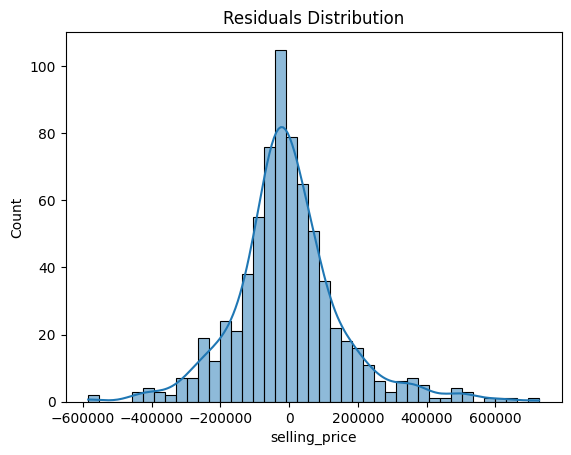

In [27]:
residuals = ytest - ypred

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

### Save model

In [28]:
BASE_DIR = os.getcwd()
MODEL_DIR = os.path.join("..", "Model")
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "full_pipeline.pkl")
joblib.dump(full_pipeline, MODEL_PATH)

['..\\Model\\full_pipeline.pkl']